# <center> Counting different scenarios </center>

## Importing libraries

In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image
import torch
import torchvision

## Loading variables

In [2]:
tp = np.load('../tables/tp.npy')
fp = np.load('../tables/fp.npy')
tp_corners = np.load('../tables/tp_corners.npy')
fp_corners = np.load('../tables/fp_corners.npy')
fn_corners = np.load('../tables/fn_corners.npy')

## Loading RGB and its dimensions

In [3]:
rgb_array = np.load('../tables/rgb_test.npy')

print(f"The dimensions of the RGB array are {rgb_array.shape}")

array_height = rgb_array.shape[0]
array_width = rgb_array.shape[1]

The dimensions of the RGB array are (20145, 17761, 3)


## Computing number of patches in the image

The number of windows with some overlap contained on each axis follows the formula: <br>
$ window range = window nb*window step + overlap $ <br>
which is equivalent to $ window nb = (window range - overlap)/windowstep $ <br>
with $overlap = window size - window step$

In [4]:
wdw_nb_y = (array_height-60)/210
wdw_nb_y = math.floor(wdw_nb_y)
print(f'Patches in the y direction: {wdw_nb_y}.')

wdw_nb_x = (array_width-60)/210
wdw_nb_x = math.floor(wdw_nb_x)
print(f'Patches in the x direction: {wdw_nb_x}.')

wdw_nb = wdw_nb_x*wdw_nb_y
print(f'Total number of patches: {wdw_nb}.')

Patches in the y direction: 95.
Patches in the x direction: 84.
Total number of patches: 7980.


## Computing the corners of each patch

In [5]:
moving_window_step = 210
large_window_size = 270 

steps_nb_y = int((array_height-large_window_size) / moving_window_step) + 1
print(f" The number of steps in the y direction is :{steps_nb_y}")

steps_nb_x = int((array_width-large_window_size) / moving_window_step) + 1
print(f" The number of steps in the x direction is :{steps_nb_x}")

wdw_corners = []

for step_y in range(steps_nb_y):    
    for step_x in range(steps_nb_x): 

        wdw_x1 = step_x*moving_window_step
        wdw_y1 = step_y*moving_window_step
        wdw_x2 = step_x*moving_window_step + large_window_size
        wdw_y2 = step_y*moving_window_step + large_window_size
        wdw_corners.append([wdw_x1, wdw_y1, wdw_x2, wdw_y2])
        
wdw_corners = np.array(wdw_corners)

 The number of steps in the y direction is :95
 The number of steps in the x direction is :84


## Loop for counting how many TP, FP and FN on each patch

### Computing IoU matrices

In [6]:
wdw_iou_matrix_tp = torchvision.ops.box_iou(torch.from_numpy(wdw_corners), torch.from_numpy(tp_corners))
wdw_iou_matrix_fp = torchvision.ops.box_iou(torch.from_numpy(wdw_corners), torch.from_numpy(fp_corners))
wdw_iou_matrix_fn = torchvision.ops.box_iou(torch.from_numpy(wdw_corners), torch.from_numpy(fn_corners))

wdw_iou_matrix_tp = wdw_iou_matrix_tp.numpy()
wdw_iou_matrix_fp = wdw_iou_matrix_fp.numpy()
wdw_iou_matrix_fn = wdw_iou_matrix_fn.numpy()

In [7]:
tp_per_wdw = np.zeros(wdw_nb, dtype=int)
fp_per_wdw = np.zeros(wdw_nb, dtype=int)
fn_per_wdw = np.zeros(wdw_nb, dtype=int)

tp_corners_per_wdw = []
fp_corners_per_wdw = []

box_edge = 90
patch_threshold = 0.5
patch_threshold_scaled = patch_threshold * (box_edge**2) / (large_window_size**2)

# for each patch
for i in range(wdw_nb):
    num_inter_thr_tp = np.sum(wdw_iou_matrix_tp[i, :] >= patch_threshold_scaled)
    tp_per_wdw[i] = num_inter_thr_tp
    tp_index = np.where(wdw_iou_matrix_tp[i, :] >= patch_threshold_scaled)
    tp_corners_per_wdw.append(tp_corners[tp_index])
    
    num_inter_thr_fp = np.sum(wdw_iou_matrix_fp[i, :] >= patch_threshold_scaled)
    fp_per_wdw[i] = num_inter_thr_fp
    fp_index = np.where(wdw_iou_matrix_fp[i, :] >= patch_threshold_scaled)
    fp_corners_per_wdw.append(fp_corners[fp_index])
    
    num_inter_thr_fn = np.sum(wdw_iou_matrix_fn[i, :] >= patch_threshold_scaled)
    fn_per_wdw[i] = num_inter_thr_fn 

### Reshaping vectors and concatenating into matrix

In [8]:
tp_per_wdw = tp_per_wdw.reshape(-1,1)
fp_per_wdw = fp_per_wdw.reshape(-1,1)
fn_per_wdw = fn_per_wdw.reshape(-1,1)

In [9]:
wdw_scenarios = np.concatenate((tp_per_wdw, fp_per_wdw, fn_per_wdw), axis=1)

## Visualizing number of scenarios

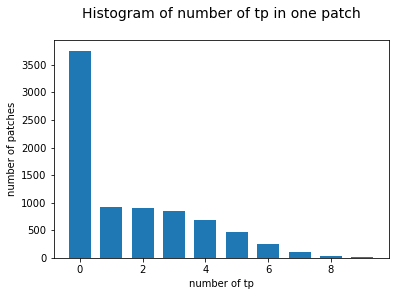

In [10]:
fig, ax = plt.subplots()

ax.hist(tp_per_wdw, align='left', rwidth=0.7)
ax.set_xlabel('number of tp')
ax.set_ylabel('number of patches')
ax.set_title('Histogram of number of tp in one patch\n', fontsize=14)

plt.show()

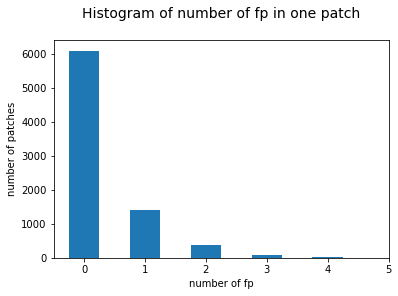

In [11]:
fig, ax = plt.subplots()

ax.hist(fp_per_wdw, align='left')
ax.set_xlabel('number of fp')
ax.set_ylabel('number of patches')
ax.set_title('Histogram of number of fp in one patch\n', fontsize=14)

plt.show()

## Looking at different scenarios with pandas dataframe

### Transforming numpy array into a pandas dataframe

In [12]:
print(wdw_scenarios.shape)
print(type(wdw_scenarios))

(7980, 3)
<class 'numpy.ndarray'>


In [13]:
wdw_scenarios = pd.DataFrame(wdw_scenarios)

In [14]:
print(wdw_scenarios.shape)
print(type(wdw_scenarios))

(7980, 3)
<class 'pandas.core.frame.DataFrame'>


### Changing the column names of the dataframe

In [15]:
wdw_scenarios.head()

,0,1,2
0,2,1,0
1,3,0,0
2,1,0,0
3,1,0,0
4,1,0,0


In [16]:
wdw_scenarios.rename(columns={0: 'TP', 1: 'FP', 2: 'FN'}, inplace=True)

In [17]:
wdw_scenarios.head()

,TP,FP,FN
0,2,1,0
1,3,0,0
2,1,0,0
3,1,0,0
4,1,0,0


### Counting different possible scenarios

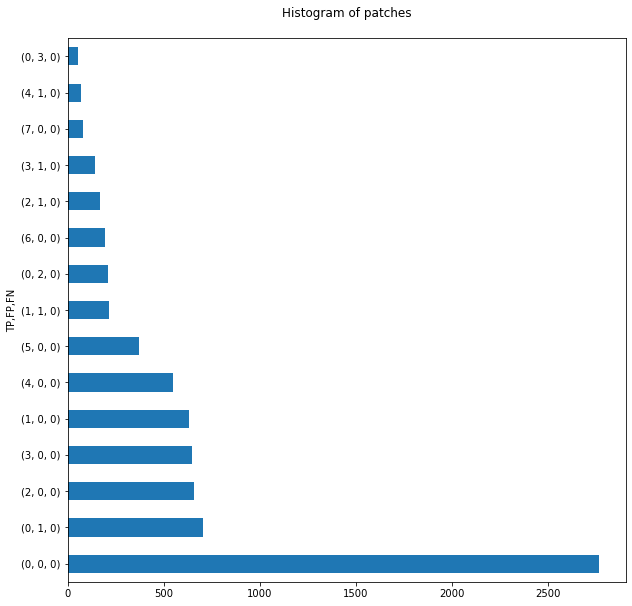

In [18]:
plt.figure()
wdw_scenarios.value_counts().head(15).plot(kind='barh', figsize=(10,10),
                                                         title='Histogram of patches\n')
plt.show()

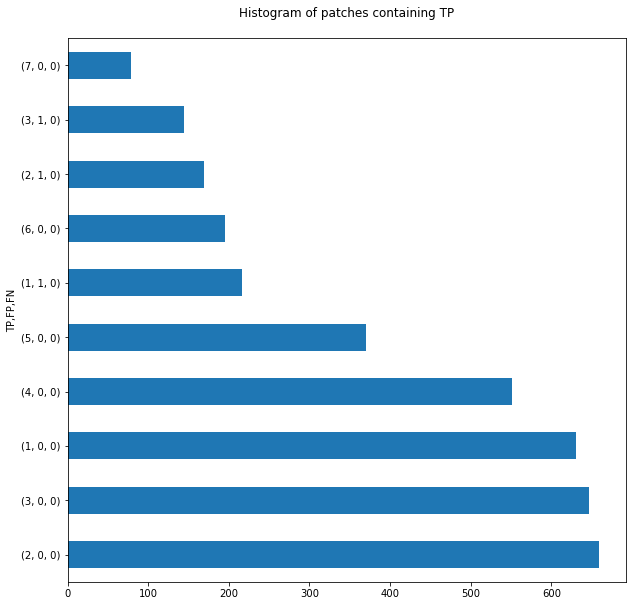

In [19]:
plt.figure()
wdw_scenarios[wdw_scenarios['TP']>0].value_counts().head(10).plot(kind='barh', figsize=(10,10),
                                                         title='Histogram of patches containing TP\n')
plt.show()

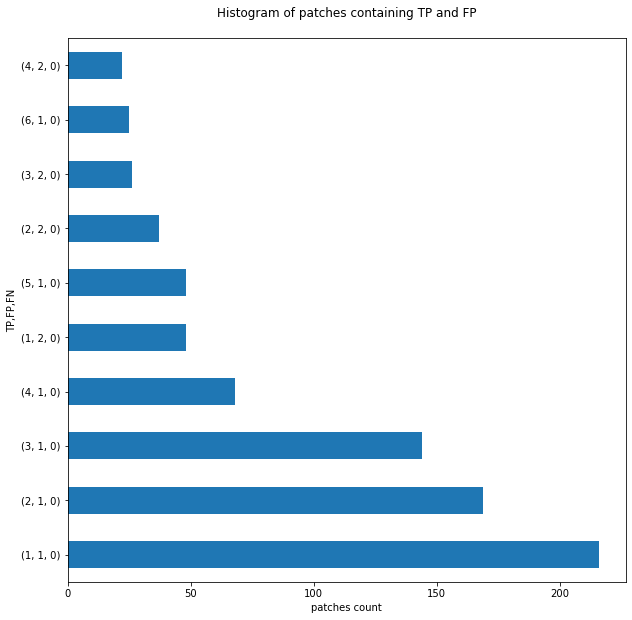

In [20]:
plt.figure()
wdw_scenarios.query("TP > 0 & FP > 0 & FN == 0").value_counts().head(10).plot(kind='barh',
                                                                    figsize=(10,10),
                                                                    title='Histogram of patches containing TP and FP\n')
plt.xlabel('patches count')
plt.show()

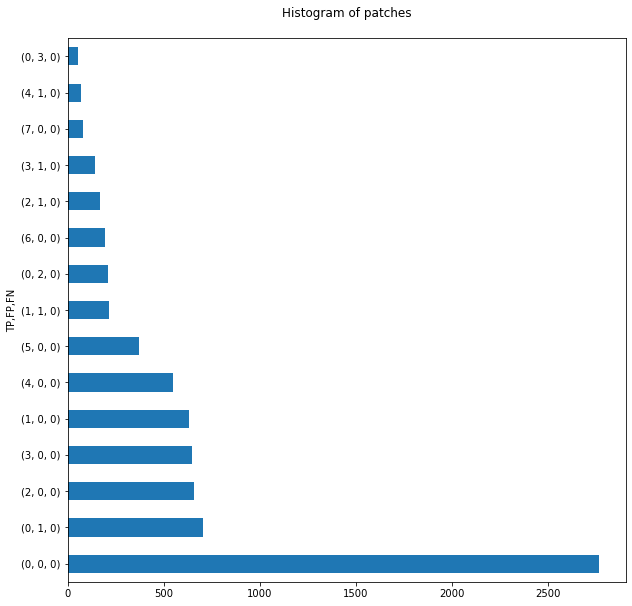

In [21]:
plt.figure()
wdw_scenarios.value_counts().head(15).plot(kind='barh',
                                           figsize=(10,10),
                                           title='Histogram of patches\n')
plt.show()

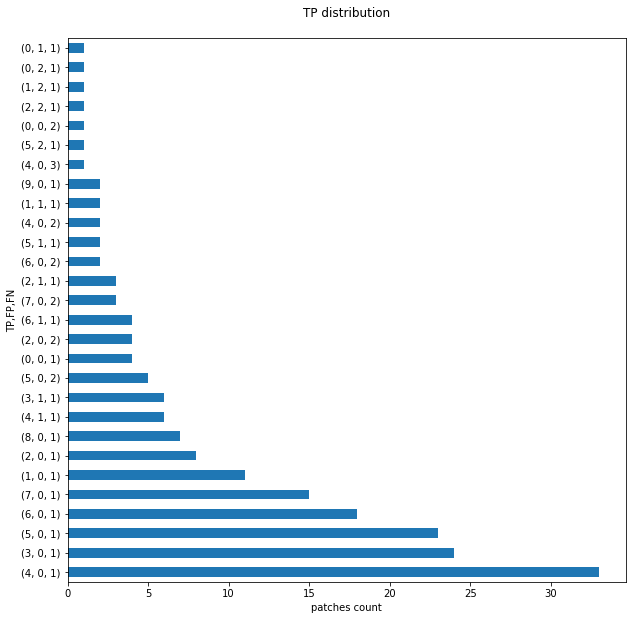

In [22]:
plt.figure()
wdw_scenarios.query("FN > 0").value_counts().plot(kind='barh', 
                                                  figsize=(10,10), 
                                                  title = 'TP distribution\n')
plt.xlabel('patches count')
plt.show()

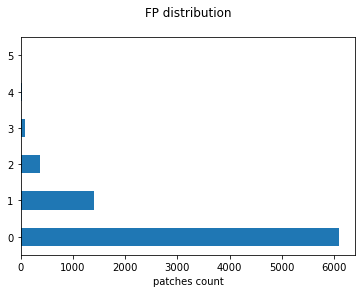

In [23]:
plt.figure()
wdw_scenarios['FP'].value_counts().plot(kind='barh',
                                       title='FP distribution\n')
plt.xlabel('patches count')
plt.show()

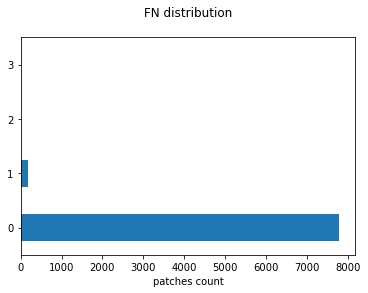

In [24]:
plt.figure()
wdw_scenarios['FN'].value_counts().plot(kind='barh',
                                       title='FN distribution\n')
plt.xlabel('patches count')
plt.show()

Get the index of the windows scenarios to have the corresponding coordinates of the corners of the patches.

In [25]:
wdw_scenarios.query("TP > 5 & FP > 0 & FN == 0").index.tolist()

[108,
 214,
 470,
 518,
 1386,
 1789,
 2112,
 2229,
 2277,
 2752,
 3119,
 3330,
 3331,
 3905,
 4157,
 4636,
 4637,
 4788,
 4902,
 5419,
 5550,
 5882,
 5967,
 6080,
 6892,
 6975,
 7077,
 7524,
 7608,
 7661,
 7692,
 7749,
 7752,
 7833]

## Displaying some patches

### Defining some functions

In [26]:
def drawingfrom_diagonalcorners_3bands(coordinates, array_3bands, colors):
    """boxsize input needs to be even"""
    linewidth=2
    x1, y1, x2, y2 = coordinates[0], coordinates[1], coordinates[2], coordinates[3]
    
    for i in range(3):
        array_3bands[y1:(y1+90),x1:x1+linewidth, i] = colors[i]
        array_3bands[y1:y1+linewidth, x1:(x1+90), i] = colors[i]
        array_3bands[y1:(y1+90), x2:x2+linewidth, i] = colors[i]
        array_3bands[y2:y2+linewidth, x1:(x1+90+2), i] = colors[i]
              
    return

In [27]:
def plot_patch(i, rgb_path):
    
    rgb = np.load(rgb_path)
    green = np.array([0,255,0])
    red = np.array([255,0,0])
    
    for j in range(tp_corners_per_wdw[i].shape[0]):
        tp_corners = tp_corners_per_wdw[i][j]
        drawingfrom_diagonalcorners_3bands(tp_corners, rgb, green)
        
    for k in range(fp_corners_per_wdw[i].shape[0]):
        drawingfrom_diagonalcorners_3bands(fp_corners_per_wdw[i][k], rgb, red)
    
    corners = wdw_corners[i]
    x1,y1,x2,y2 = corners
    plt.figure(figsize=(6,6))
    plt.imshow(rgb[y1:y2,x1:x2:])
    plt.title('Cropped RGB\n', fontsize=16)
    plt.show()
    
    return

In [28]:
rgb_path = '../tables/rgb_test.npy'

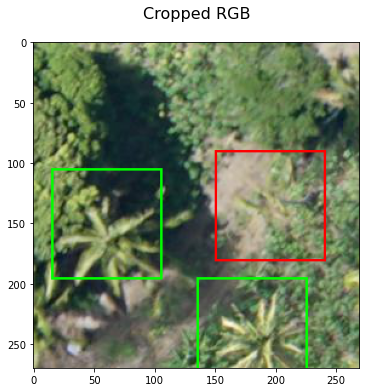

In [29]:
plot_patch(0, rgb_path)

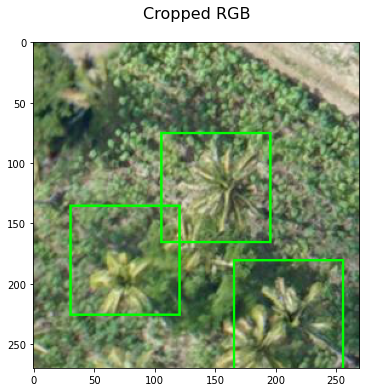

In [30]:
plot_patch(1, rgb_path)

## Saving patches with charactesitics as PNG

In [31]:
wdw_scenarios.query("TP == 1 & FP == 3 & FN == 0").index.tolist()

[2879, 3159, 3972, 4047, 4821, 5377, 7210, 7659, 7831]

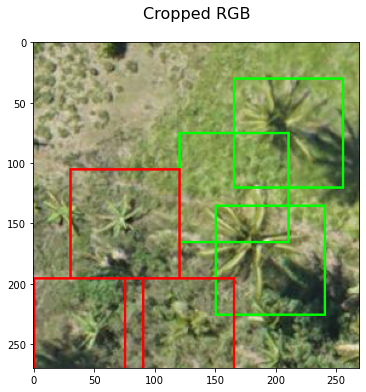

In [32]:
plot_patch(7588, rgb_path)

In [33]:
def save_patch_tp(i, rgb_path, save_path):
    '''This function saves only the patch with its corresponding tp detections.
    save_path is the path + the name + extension of the image.'''
    rgb = np.load(rgb_path)
    green = np.array([0,255,0])
    red = np.array([255,0,0])
    
    for j in range(tp_corners_per_wdw[i].shape[0]):
        tp_corners = tp_corners_per_wdw[i][j]
        drawingfrom_diagonalcorners_3bands(tp_corners, rgb, green)
    
    corners = wdw_corners[i]
    x1,y1,x2,y2 = corners
    im = Image.fromarray(rgb[y1:y2,x1:x2:])    
    im.save(save_path)
    
    return

In [34]:
help(save_patch_tp)

Help on function save_patch_tp in module __main__:

save_patch_tp(i, rgb_path, save_path)
    This function saves only the patch with its corresponding tp detections.
    save_path is the path + the name + extension of the image.



In [35]:
query_length = len(wdw_scenarios.query("TP == 1 & FP == 1 & FN == 0").index.tolist())
print(query_length)

216


code to find scenarios and save them as image

In [36]:
query = wdw_scenarios.query("TP == 0 & FP == 3 & FN == 0").index.tolist()
i=0
for i in range(len(query)):
    
    saving_name = "tp0_fp3_fn0_" + str(i) + ".png"
    saving_location = "../experiment/"
    path_to_palm = saving_location + saving_name
    
    save_patch_tp(query[i], rgb_path, path_to_palm)
    
    if i == 9:
        break
        
    i+=1

## Saving scenarios to dictionaries and then as pickles

https://www.kite.com/python/answers/how-to-save-a-dictionary-to-a-file-in-python

In [46]:
tp_corners_per_wdw[0]

array([[ 15, 105, 105, 195],
       [135, 195, 225, 285]])

In [47]:
tp_dict = {'0':f'{tp_corners_per_wdw[0]}'}

In [48]:
print(tp_dict.get('0'))

[[ 15 105 105 195]
 [135 195 225 285]]


In [50]:
tp_dict = {}
print(type(tp_dict))

<class 'dict'>


In [51]:
for i in range(len(tp_corners_per_wdw)):
    tp_dict[f'{i}'] = tp_corners_per_wdw[i]

In [53]:
print(tp_dict.get('7'))

[[1545  105 1635  195]
 [1635  165 1725  255]
 [1515   15 1605  105]]
